In [17]:
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
import matplotlib.pyplot as plt
import networkx as nx
from matplotlib.colors import ListedColormap

# Загрузка CSV
nodes = pd.read_csv('data/nodes.csv', parse_dates=['last_login_time'])
edges = pd.read_csv('data/edges.csv', parse_dates=['timestamp'])
resources = pd.read_csv('data/resources.csv')

edges['timestamp'] = pd.to_datetime(edges['timestamp'], errors='coerce')

# Преобразование timestamp в Unix-время
edges['timestamp_unix'] = edges['timestamp'].astype('int64') // 10**9  # В секундах
nodes['last_login_unix'] = nodes['last_login_time'].astype('int64') // 10**9

# Нормализация признаков
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
node_features = scaler.fit_transform(nodes[['login_count', 'access_level', 'var_activity']])
# Превращаем resource_features в массив признаков
resource_features = scaler.fit_transform(resources[['access_count_last_month']])

unique_resources = sorted(set(edges['target_resource']))
resource_map = {rid: idx for idx, rid in enumerate(unique_resources)}

assert edges['source_user'].max() < len(nodes), "Есть некорректные индексы пользователей!"
assert edges['target_resource'].max() < len(resources), "Есть некорректные индексы ресурсов!"

# Создание тензоров
node_features = torch.tensor(node_features, dtype=torch.float)
resource_features = torch.tensor(resource_features, dtype=torch.float)
edge_index = torch.tensor([edges['source_user'].values, edges['target_resource'].values], dtype=torch.long)



In [18]:
#edge_attr = torch.tensor(edges[['weight', 'timestamp_unix']].values, dtype=torch.float)

# Теперь добавляем признак ресурса в каждое ребро, соответствующее этому ресурсу
edge_attr = []
for idx, row in edges.iterrows():
    res_idx = resource_map.get(row['target_resource'], None)
    if res_idx is not None:
        feature_value = float(resource_features[res_idx])
        original_attrs = [row['weight'], row['timestamp_unix']]
        new_attrs = original_attrs + [feature_value]
        edge_attr.append(new_attrs)

# Пример меток (замените на реальные данные)
labels = torch.tensor([0] * len(node_features), dtype=torch.long)  # Все узлы пока "нормальные"

print("Число узлов:", len(node_features))
print("Число меток:", len(labels))

# Приводим к нужному формату
edge_attr_tensor = torch.tensor(edge_attr, dtype=torch.float)



Число узлов: 20
Число меток: 20


In [19]:
edge_attr

[[0.878411779110629, 1731511826, 0.6355217695236206],
 [0.554265596383152, 1735234226, -1.508945345878601],
 [0.326336558670067, 1733931026, -0.6734967231750488],
 [0.927743811477137, 1733747426, 0.045793309807777405],
 [0.971606316744734, 1716478226, 1.649675965309143],
 [0.182944630102846, 1720618226, -0.1597181260585785],
 [0.251471714931867, 1740929426, -1.240886926651001],
 [0.34406797223793, 1732278566, -0.6734967231750488],
 [0.354243767681781, 1737646226, 0.045793309807777405],
 [0.613158877489808, 1737041426, 0.045793309807777405],
 [0.78664282123005, 1740151826, 1.5335173606872559],
 [0.168137339301706, 1717432226, -0.1597181260585785],
 [0.304499053255874, 1742916626, 1.5335173606872559],
 [0.413810887184509, 1729614626, -1.508945345878601],
 [0.218190469357945, 1720366226, 0.045793309807777405],
 [0.891035421350068, 1737127826, 1.5335173606872559],
 [0.60468730953079, 1740583226, -0.1597181260585785],
 [0.257264274197876, 1743003026, -0.6734967231750488],
 [0.32010309062078

In [20]:
edge_attr_tensor

tensor([[ 8.7841e-01,  1.7315e+09,  6.3552e-01],
        [ 5.5427e-01,  1.7352e+09, -1.5089e+00],
        [ 3.2634e-01,  1.7339e+09, -6.7350e-01],
        [ 9.2774e-01,  1.7337e+09,  4.5793e-02],
        [ 9.7161e-01,  1.7165e+09,  1.6497e+00],
        [ 1.8294e-01,  1.7206e+09, -1.5972e-01],
        [ 2.5147e-01,  1.7409e+09, -1.2409e+00],
        [ 3.4407e-01,  1.7323e+09, -6.7350e-01],
        [ 3.5424e-01,  1.7376e+09,  4.5793e-02],
        [ 6.1316e-01,  1.7370e+09,  4.5793e-02],
        [ 7.8664e-01,  1.7402e+09,  1.5335e+00],
        [ 1.6814e-01,  1.7174e+09, -1.5972e-01],
        [ 3.0450e-01,  1.7429e+09,  1.5335e+00],
        [ 4.1381e-01,  1.7296e+09, -1.5089e+00],
        [ 2.1819e-01,  1.7204e+09,  4.5793e-02],
        [ 8.9104e-01,  1.7371e+09,  1.5335e+00],
        [ 6.0469e-01,  1.7406e+09, -1.5972e-01],
        [ 2.5726e-01,  1.7430e+09, -6.7350e-01],
        [ 3.2010e-01,  1.7251e+09,  1.5335e+00],
        [ 1.9158e-01,  1.7426e+09, -9.2815e-01],
        [ 7.3179e-01

In [21]:
data = Data(x=node_features, edge_index=edge_index, edge_attr=edge_attr_tensor, y=labels)

print(f"x.shape: {data.x.shape}")
print(f"edge_index max: {data.edge_index.max()}, min: {data.edge_index.min()}")

num_nodes = data.x.size(0)
max_index = data.edge_index.max().item()
assert max_index < num_nodes, f"Edge index {max_index} exceeds number of nodes {num_nodes}"

x.shape: torch.Size([20, 3])
edge_index max: 19, min: 0


Epoch 0, Loss: 1.2232
Epoch 1, Loss: 0.5670
Epoch 2, Loss: 0.2227
Epoch 3, Loss: 0.0780
Epoch 4, Loss: 0.0262
Epoch 5, Loss: 0.0089
Epoch 6, Loss: 0.0032
Epoch 7, Loss: 0.0012
Epoch 8, Loss: 0.0005
Epoch 9, Loss: 0.0002
Epoch 10, Loss: 0.0001
Epoch 11, Loss: 0.0000
Epoch 12, Loss: 0.0000
Epoch 13, Loss: 0.0000
Epoch 14, Loss: 0.0000
Epoch 15, Loss: 0.0000
Epoch 16, Loss: 0.0000
Epoch 17, Loss: 0.0000
Epoch 18, Loss: 0.0000
Epoch 19, Loss: 0.0000
Epoch 20, Loss: 0.0000
Epoch 21, Loss: 0.0000
Epoch 22, Loss: 0.0000
Epoch 23, Loss: 0.0000
Epoch 24, Loss: 0.0000
Epoch 25, Loss: 0.0000
Epoch 26, Loss: 0.0000
Epoch 27, Loss: 0.0000
Epoch 28, Loss: 0.0000
Epoch 29, Loss: 0.0000
Epoch 30, Loss: 0.0000
Epoch 31, Loss: 0.0000
Epoch 32, Loss: 0.0000
Epoch 33, Loss: 0.0000
Epoch 34, Loss: 0.0000
Epoch 35, Loss: 0.0000
Epoch 36, Loss: 0.0000
Epoch 37, Loss: 0.0000
Epoch 38, Loss: 0.0000
Epoch 39, Loss: 0.0000
Epoch 40, Loss: 0.0000
Epoch 41, Loss: 0.0000
Epoch 42, Loss: 0.0000
Epoch 43, Loss: 0.000

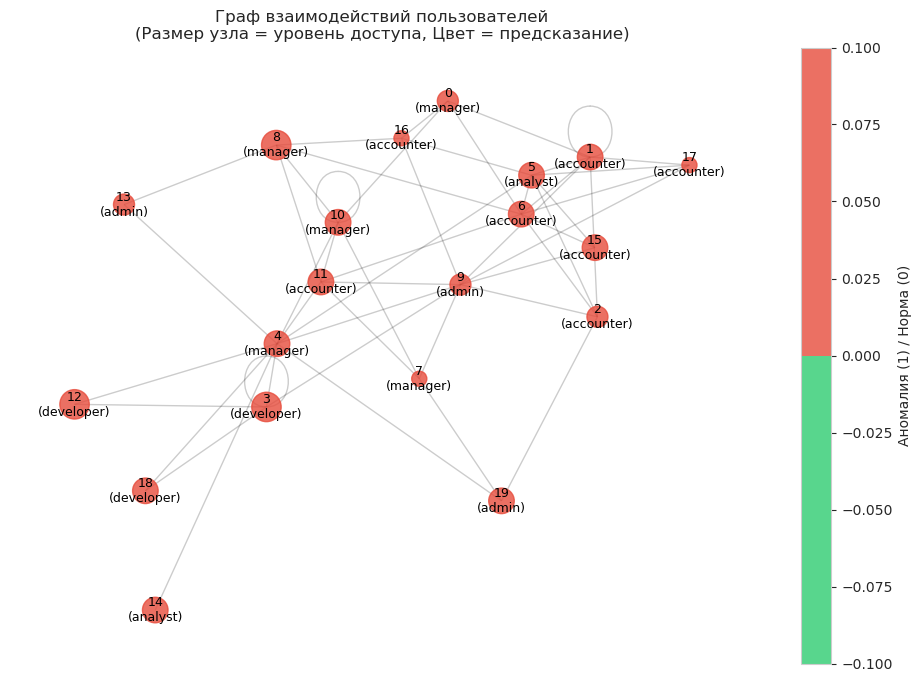

In [22]:
loader = DataLoader([data], batch_size=1)

class HybridModel(nn.Module):
    def __init__(self, num_node_features, num_edge_features, hidden_dim):
        super().__init__()
        # GCN часть
        self.gcn1 = GCNConv(num_node_features, hidden_dim)
        self.gcn2 = GCNConv(hidden_dim, hidden_dim)

        # LSTM для обработки временных меток
        self.lstm = nn.LSTM(input_size=num_edge_features+1,  # +1 потому что добавлен один признак ресурса
                           hidden_size=hidden_dim,
                           batch_first=True)
        # Классификатор
        self.fc = nn.Linear(hidden_dim * 2, 2)  # Умножаем на 2, так как объединяем GCN и LSTM выходы

    def forward(self, data):
        # Обработка графа
        x = F.relu(self.gcn1(data.x, data.edge_index))
        x_gcn = self.gcn2(x, data.edge_index)  # [num_nodes, hidden_dim]

        # Обработка временных признаков
        edge_attr = data.edge_attr.unsqueeze(0)  # [1, num_edges, num_edge_features]
        _, (h_n, _) = self.lstm(edge_attr)
        lstm_out = h_n.squeeze(0)  # [1, hidden_dim]

        # Применяем GCN признаки к каждому узлу
        gcn_out = x_gcn  # [num_nodes, hidden_dim]

        # Повторяем LSTM выход для каждого узла
        lstm_repeated = lstm_out.repeat(gcn_out.size(0), 1)  # [num_nodes, hidden_dim]

        # Объединение признаков
        combined = torch.cat([gcn_out, lstm_repeated], dim=1)  # [num_nodes, hidden_dim * 2]

        return F.log_softmax(self.fc(combined), dim=1)

# Инициализация модели
model = HybridModel(
    num_node_features=3,  # login_count, access_level, var_activity
    num_edge_features=2,  # weight и timestamp_unix
    hidden_dim=64
)

# Обучение
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

def train():
    model.train()
    for batch in loader:
        optimizer.zero_grad()
        out = model(batch)  # [num_nodes, 2]
        loss = criterion(out, batch.y)  # Сравниваем с [num_nodes]
        loss.backward()
        optimizer.step()
    return loss.item()

for epoch in range(100):
    loss = train()
    print(f'Epoch {epoch}, Loss: {loss:.4f}')

# Проверка предсказаний
model.eval()
with torch.no_grad():
    out = model(data)
    predictions = out.argmax(dim=1)
    print("Predictions:", predictions)


def visualize_graph(data, predictions, node_roles):
    G = nx.Graph()

    # Проверяем, что node_roles достаточно длинный
    if len(node_roles) < len(data.x):
        print(f"Предупреждение: node_roles содержит {len(node_roles)} элементов, а узлов — {len(data.x)}.")
        # Заполняем недостающие роли значением по умолчанию
        node_roles += ['unknown'] * (len(data.x) - len(node_roles))

    # Добавляем узлы с атрибутами
    #for i in range(len(data.x)):
    for i in range(min(len(data.x), len(node_roles))):
        G.add_node(i,
                  role=node_roles[i],  # Используем переданный список ролей
                  pred=int(predictions[i]),
                  conf=float(torch.exp(out[i]).max()))

    # Добавляем рёбра с весами
    for src, dst in data.edge_index.t().numpy():
        G.add_edge(src, dst, weight=float(data.edge_attr[src][0]))

    # Цвета узлов
    cmap = ListedColormap(['#2ecc71', '#e74c3c'])  # Зелёный=норма, Красный=аномалия
    node_colors = [G.nodes[n]['pred'] for n in G.nodes]

    # Размеры узлов по уровню доступа
    node_sizes = [300 + 100*data.x[i][1].item() for i in G.nodes]  # access_level

    # Позиции узлов
    pos = nx.spring_layout(G, seed=42)

    plt.figure(figsize=(12, 8))

    # Рисуем рёбра
    nx.draw_networkx_edges(G, pos, alpha=0.2, width=1)

    # Рисуем узлы
    nodes_draw = nx.draw_networkx_nodes(
        G, pos,
        node_color=node_colors,
        cmap=cmap,
        node_size=node_sizes,
        alpha=0.8
    )

    # Подписи узлов
    labels = {n: f"{n}\n({G.nodes[n]['role']})" for n in G.nodes}
    nx.draw_networkx_labels(G, pos, labels, font_size=9)

    # Легенда
    plt.colorbar(nodes_draw, label="Аномалия (1) / Норма (0)")
    plt.title("Граф взаимодействий пользователей\n(Размер узла = уровень доступа, Цвет = предсказание)")
    plt.axis('off')
    plt.show()

# Список ролей пользователей
node_roles = nodes['role'].tolist()  # Замените 'role' на имя нужной колонки
#node_roles = ['manager', 'developer', 'analyst', 'developer', 'manager',
 #             'analyst', 'developer', 'manager', 'analyst', 'developer']

# Вызов функции визуализации
visualize_graph(data, predictions, node_roles)
